# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multiclass image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

The evaluation metric is multi-class log loss between the predicted probability and the observed target.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000 images in the training set (these images have labels).
* There are around 10,000 images in the test set (these images have no labels).


### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [111]:
# Import necessary tools
import os
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Check for GPU availability
print('GPU', 'available (YES!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

TF version: 2.15.0
TF Hub version: 0.16.1
GPU not available :(


In [112]:
# Create a function to save a model
def save_model(model, suffix=None):
  '''
  Saves a given model in a models directory and appends a suffix (string).
  '''
  # Create a model directory pathname with current time
  modeldir = os.path.join('Dog Vision/models', datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + '.h5' # save format of model
  print(f'Saving model to: {model_path}...')
  model.save(model_path)
  return model_path

# Create a function to load a trained model
def load_model(model_path):
  '''
  Loads a saved model from a specified path.
  '''
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer': hub.KerasLayer})

  return model

## Getting our data ready (turning into tensors)

With all machine learing models, our data has to be in numerical format. So that's what we'll be doing first: turning our images into tensors (numerical representation).

Let's start by accessing our data and checking out the labels.

In [3]:
# Check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv('Dog Vision/labels.csv')
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [4]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

<Axes: >

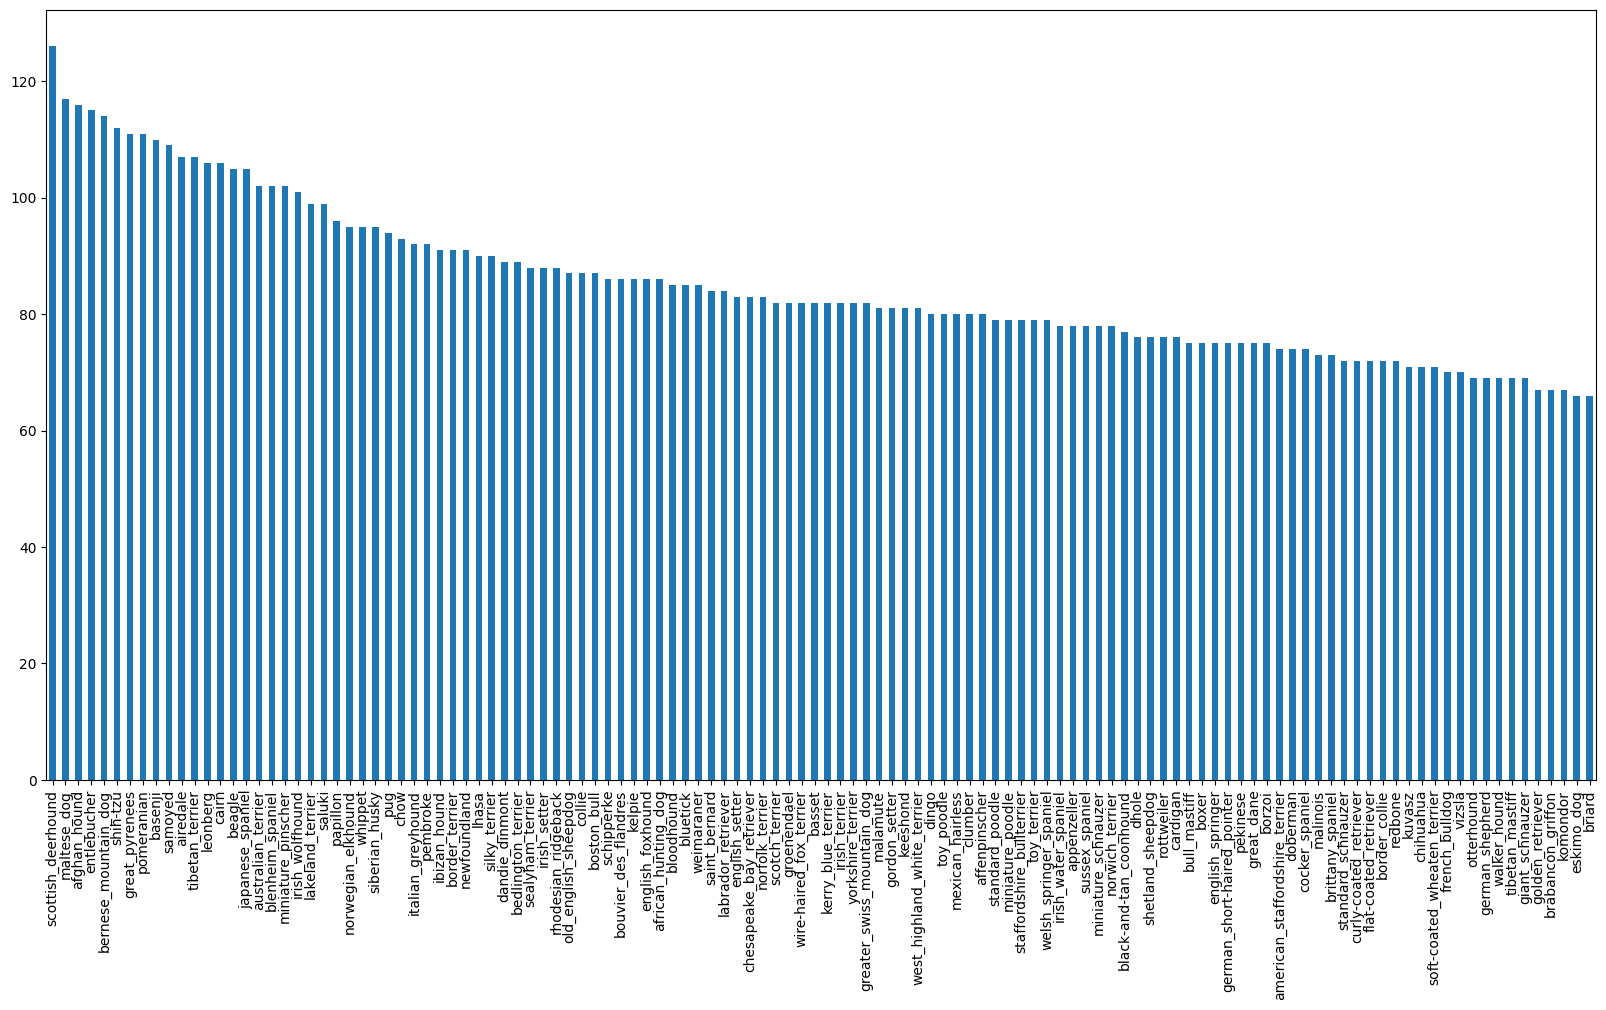

In [5]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [6]:
labels_csv['breed'].value_counts().median()

82.0

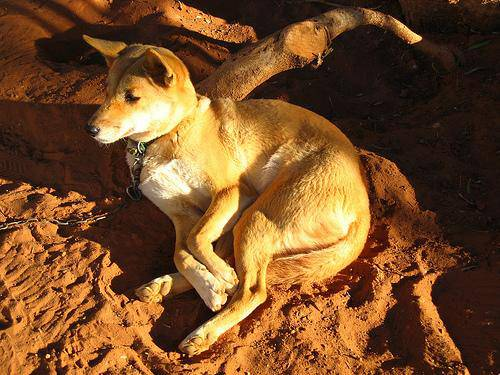

In [7]:
# Let's view an image
from IPython.display import Image
Image('Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all our image file pathnames.

In [8]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [9]:
# Create pathnames from image IDs
filenames = ['Dog Vision/train/' + fname + '.jpg' for fname in labels_csv['id']]

filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files
import os
len(os.listdir('Dog Vision/train')), len(filenames)

(10222, 10222)

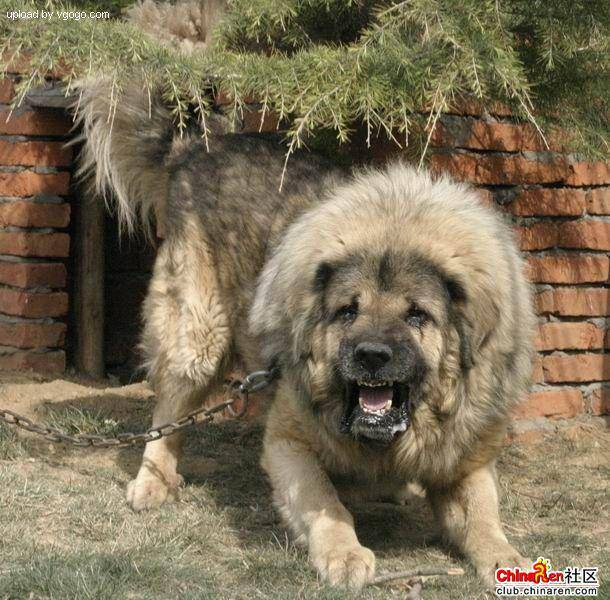

In [11]:
# One more check
Image(filenames[9000])

In [12]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [13]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches the number of filenames
len(labels), len(filenames)

(10222, 10222)

In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds
# The above expression takes a label (e.g., 'labrador'), and searches
# unique_breeds array for that label, by going thru all 120 elements
# of the unique_labels array. For the unique labels that are different
# from 'labrador', it puts 'false', and for the only label that matches
# 'labrador', it puts true. It returns this whole thing as a new 1D array.

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [20]:
# Set up X and y variables
X = filenames
y = boolean_labels

In [21]:
len(X), len(y)

(10222, 10222)

We're going to start off experimenting with ~1000 images and increase as needed.

In [22]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000

In [23]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validaiton of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [24]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224, 3)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [25]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [26]:
image.max(), image.min()

(255, 0)

In [27]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [28]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we come to the function.

In [29]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  '''
  Takes an image file path and turns the image into a Tensor.
  '''
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go. They all might not fit into memory!

So that's why we do about 32 images (this is batch size) at a time. You can manually adjust the batch size if need be.

In order to use TensorFlow effectively, we need our data to be in the form of Tensor tuples which looks like this:

`(image, label)`

In [30]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  '''
  Takes an image file path and the associated label.
  Processes the image and returns a tuple of (image, label).
  '''
  image = process_image(image_path)
  return image, label

In [31]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form `(image, label)`, let's make a function to turn all of our data (`X` and `y`) into batches!

In [32]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  It shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  '''
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Create training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping
    # image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch


In [33]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Create training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [35]:
len(y[0])

120

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to comprehend. Let's visualize them!

In [36]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  '''
  Displays a plot of 25 images and their labels from a data batch.
  '''
  # Set up the figure
  plt.figure(figsize=(10, 10))
  # Loop thru 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis('off')


In [37]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [38]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

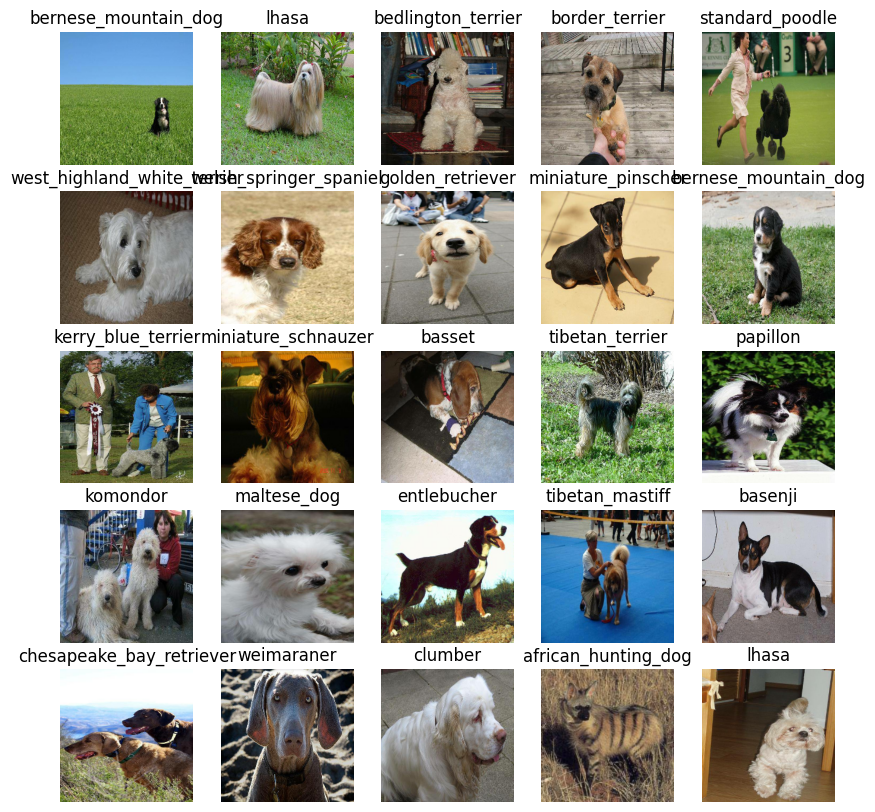

In [39]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Kaggle.

In [40]:
# Set input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Set output shape of our model
OUTPUT_SHAPE = len(unique_breeds) # 120

# Set up model URL from TensorFlow Hub
MODEL_URL = 'https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1'

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model.

Let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

In [41]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model with: ', MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation='softmax') # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [42]:
model = create_model()
model.summary()

Building model with:  https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create 2 callbacks, one for TensorBoard which helps track our model's progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To set up a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our model's training logs with the `%tensorboard` magic function (we'll do this after model training).

In [43]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [44]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('Dog Vision/logs',
                        # Make it so that the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [45]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [46]:
NUM_EPOCHS = 100

In [47]:
# Check to make sure we're still running on a GPU
print('GPU', 'available (YES!)' if tf.config.list_physical_devices('GPU') else 'not available')

GPU not available


Let's create a function which trains a model.

* Create a model using `create_model()`
* Set up a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for and the callbacks we'd like to use
* Return the model

In [48]:
def train_model():
  # Create a model
  model = create_model()

  # Create new tensorboard session every time we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  # Return the fitted model
  return model

In [51]:
# Fit the model to the data
model = train_model()

Loading saved model from: drive/My Drive/Dog Vision/models/20240315-13371710509872-1000-images-mobilenetv2-Adam.h5


### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [52]:
# %tensorboard --logdir Dog\ Vision/logs

## Making and evaluating predictions using a trained model

In [53]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [54]:
# Make predictions on the validation data (not used to train on)

predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 13s 2s/step


array([[4.7608922e-04, 2.9078836e-04, 6.6057511e-04, ..., 3.1271894e-04,
        1.8421697e-05, 1.6088506e-03],
       [2.1181777e-03, 7.2410691e-04, 1.6605175e-03, ..., 2.5741421e-03,
        3.1604234e-03, 2.0130644e-04],
       [6.4652468e-06, 4.4303164e-05, 6.4378517e-05, ..., 6.6743989e-05,
        9.8117644e-06, 3.8736084e-04],
       ...,
       [3.0654289e-06, 4.3698008e-05, 2.1014547e-04, ..., 2.0486147e-04,
        5.2904675e-04, 9.8380639e-05],
       [9.4854813e-03, 3.7865416e-04, 5.6141702e-04, ..., 2.6552795e-04,
        1.3583832e-04, 4.9112521e-02],
       [1.0989172e-04, 6.9639515e-05, 2.7821066e-03, ..., 5.1554162e-03,
        3.7471252e-04, 3.8689762e-04]], dtype=float32)

In [55]:
predictions.shape

(200, 120)

In [56]:
len(y_val)

200

In [57]:
predictions[0]

array([4.76089219e-04, 2.90788361e-04, 6.60575111e-04, 9.12703617e-05,
       1.10056542e-04, 3.21440234e-06, 2.52426858e-03, 3.26229376e-04,
       1.98061447e-04, 2.77949177e-04, 1.97206880e-03, 1.39246025e-04,
       7.39096067e-05, 1.66632628e-04, 5.36850202e-05, 1.80759630e-03,
       1.37927942e-04, 2.22210109e-01, 7.91848015e-06, 5.44477080e-05,
       1.26444676e-04, 5.37316264e-05, 2.91839187e-05, 1.65038614e-03,
       2.27228684e-05, 6.32503798e-05, 3.76803875e-01, 3.35259974e-05,
       1.96534631e-04, 2.32454360e-04, 1.17351883e-05, 5.05964214e-04,
       4.18831885e-04, 8.04517695e-05, 6.52476796e-04, 3.43207195e-02,
       1.91518717e-04, 2.59446009e-04, 2.96919388e-05, 8.97312639e-05,
       8.94532364e-04, 4.03777995e-05, 8.24073941e-05, 2.73804704e-04,
       3.84474624e-05, 4.17583331e-04, 8.14769155e-05, 1.01793812e-04,
       4.38030023e-04, 2.33219653e-05, 3.18016042e-04, 4.81147727e-05,
       1.64475714e-04, 6.72118913e-05, 2.11498045e-04, 5.18382076e-05,
      

In [58]:
np.sum(predictions[0])

0.9999998

In [59]:
# First prediction
index = 42
print(predictions[index])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

[2.31864309e-04 1.61530421e-04 1.48264138e-04 1.99160553e-04
 4.78230882e-03 8.69447249e-05 4.88925551e-04 1.68115948e-03
 6.66117994e-03 5.94284311e-02 1.34416652e-04 2.75980401e-05
 3.05670284e-04 2.15235096e-03 2.48212484e-03 3.98398284e-03
 7.79066468e-05 1.56992290e-04 5.96755890e-05 5.37757878e-04
 5.15426727e-05 2.45997886e-04 6.36598212e-04 3.55146040e-05
 1.39354281e-02 2.55719169e-05 1.99446615e-04 1.26523853e-04
 1.02453737e-03 5.38654785e-05 1.66438913e-04 1.95471584e-04
 5.47506934e-05 1.54144873e-04 4.38791758e-04 8.33108206e-04
 2.37787273e-04 5.56653948e-04 4.38884250e-04 4.92913991e-01
 1.99107380e-04 1.47236089e-04 1.10994019e-02 2.23047755e-05
 3.95108276e-04 1.96140754e-04 8.92339085e-05 2.23456440e-03
 8.58507701e-05 1.25619292e-03 6.45007021e-05 3.42518179e-04
 1.36081158e-04 1.42628769e-03 1.33987323e-05 2.18235212e-03
 2.13029314e-04 1.58928029e-04 2.36331125e-05 2.09444879e-05
 5.90856798e-05 2.71803583e-03 2.15964392e-05 3.64058680e-04
 9.68728913e-04 6.699775

In [60]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great, but we want to be able to do it at scale. And it would be even better if we could see the image the prediction is being made on.

**Note:** Prediction probabilities are also known as confidence levels.

In [61]:
# Turn probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  '''
  Turns an array of prediction probabilities into a label
  '''
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Since our validation data is still in a batch dataset, we'll have to unbatch them to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [62]:
# Create a function to unbatch a batched dataset

def unbatchify(data):
  '''
  Takes a batch dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  '''
  images = []
  labels = []
  # Loop thru unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities
* An array of truth labels
* An array of images and an integer
* Converts the prediction probabilities to a predicted label.
* Plots the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [63]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  '''
  View the prediction, ground truth, and image for sample n
  '''
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label), color=color)

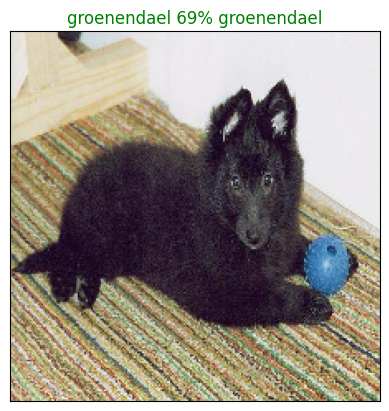

In [64]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our model's top prediction, let's make another to view our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer.
* Find the predicted label using `get_pred_label()`
* Find the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [65]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  '''
  Plot the top 10 highest prediction confidences along with the truth label for sample n.
  '''
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation='vertical')

  # Change the color of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

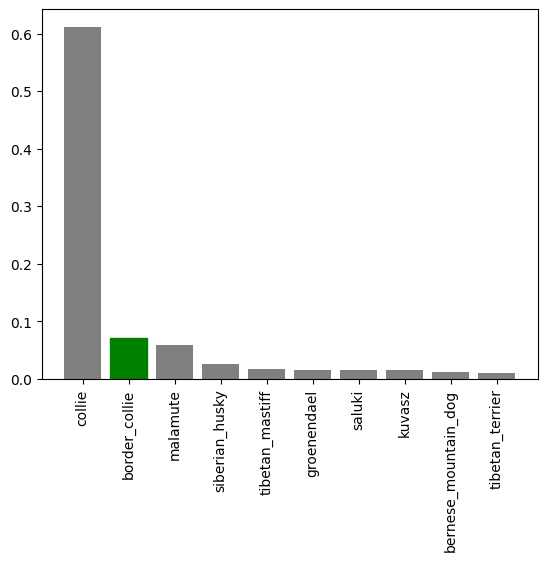

In [66]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some functions to help us visualize our predictions and evaluate our model. let's check out a few.

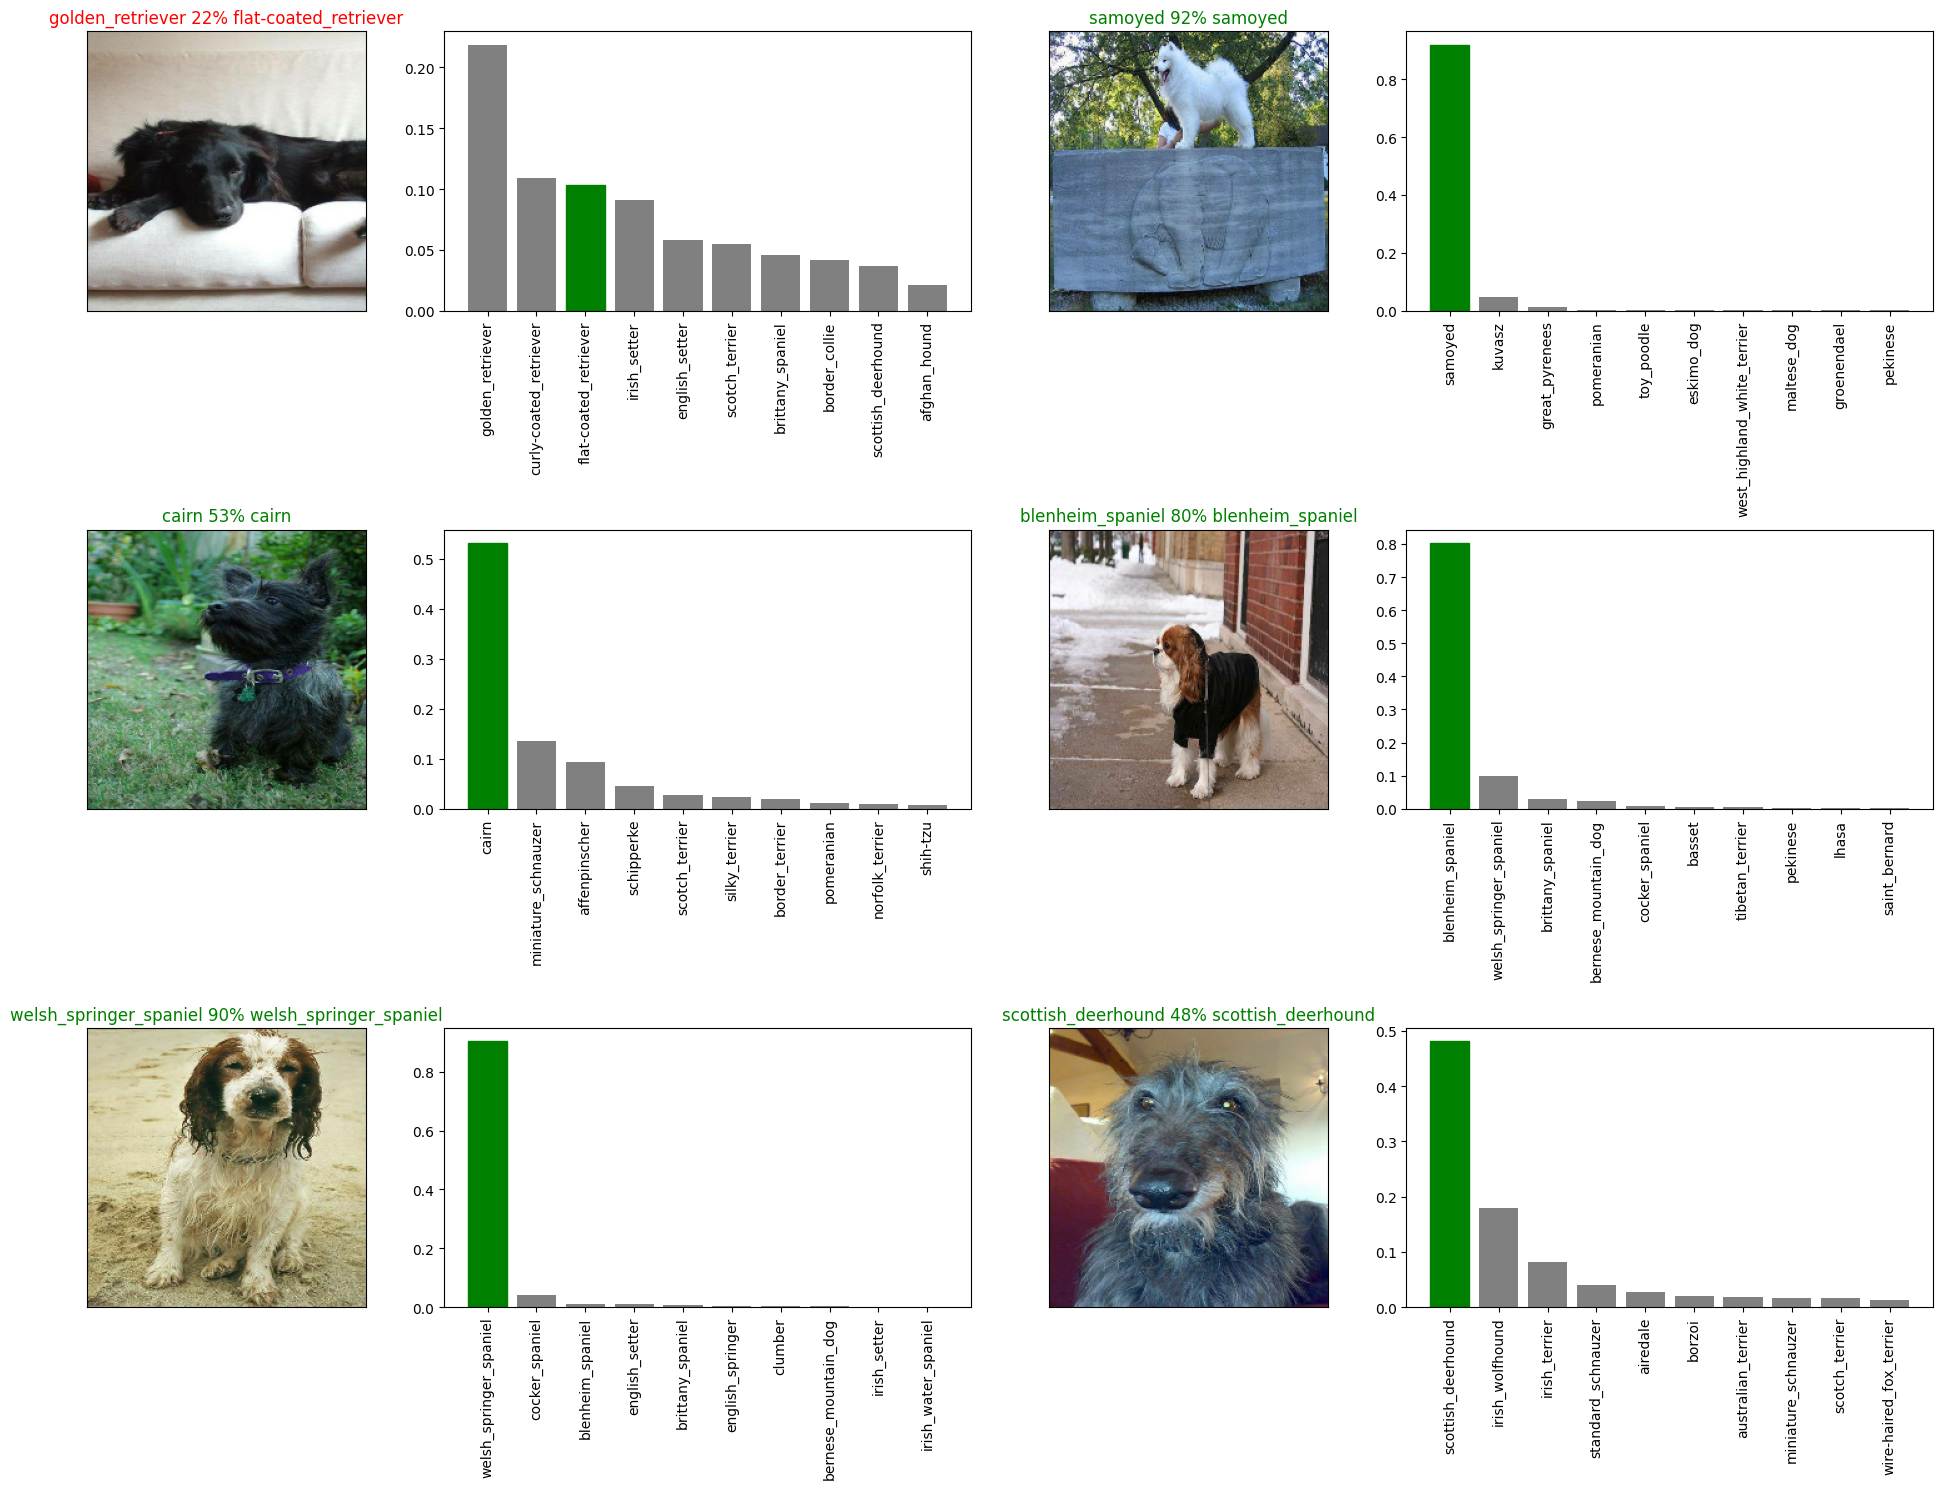

In [67]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [68]:
# Create a function to save a model
def save_model(model, suffix=None):
  '''
  Saves a given model in a models directory and appends a suffix (string).
  '''
  # Create a model directory pathname with current time
  modeldir = os.path.join('Dog Vision/models',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + '.h5' # save format of model
  print(f'Saving model to: {model_path}...')
  model.save(model_path)
  return model_path

In [69]:
# Create a function to load a trained model
def load_model(model_path):
  '''
  Loads a saved model from a specified path.
  '''
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer': hub.KerasLayer})

  return model

Now we've got functions to save and load a trained model, let's make sure they work

In [70]:
# Save our model trained on 1000 images
save_model(model, suffix='1000-images-mobilenetv2-Adam')

Saving model to: drive/My Drive/Dog Vision/models/20240317-07521710661937-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/My Drive/Dog Vision/models/20240317-07521710661937-1000-images-mobilenetv2-Adam.h5'

In [71]:
# Load a trained model
loaded_1000_image_model = load_model('Dog Vision/models/20240315-13371710509872-1000-images-mobilenetv2-Adam.h5') # IMPORTANT - pass the filename that comes after "saving model to:"
                                                                                                                  # in the above cell!

Loading saved model from: drive/My Drive/Dog Vision/models/20240315-13371710509872-1000-images-mobilenetv2-Adam.h5


In [72]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 13s 2s/step - loss: 1.2486 - accuracy: 0.6550


[1.2486168146133423, 0.6549999713897705]

In [73]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 11s 2s/step - loss: 1.2486 - accuracy: 0.6550


[1.2486168146133423, 0.6549999713897705]

## Training a big dog model on the full data

In [74]:
len(X), len(y)

(10222, 10222)

In [75]:
X[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [76]:
len(X_train)

800

In [77]:
len(y_train)

800

In [78]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Create training data batches...


In [79]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [80]:
# Create a model for full model
full_model = create_model()

Building model with:  https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1


In [81]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so with our early
# stopping callback, we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

**Note:** Running the cell below will take a little while! Maybe upto 30 minutes for the first epoch because the GPU we're using in the runtime has to load all of the images into memory.

In [82]:
# Fit the model to the full data
full_model.fit(x=full_data,
                epochs=NUM_EPOCHS,
                callbacks=[full_model_tensorboard, full_model_early_stopping])

Loading saved model from: drive/My Drive/Dog Vision/models/20240317-05261710653166-full-image-set-mobilenetv2-Adam.h5


In [83]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

Saving model to: drive/My Drive/Dog Vision/models/20240317-07521710661979-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20240317-07521710661979-full-image-set-mobilenetv2-Adam.h5'

In [84]:
loaded_full_model = load_model('Dog Vision/models/20240317-05261710653166-full-image-set-mobilenetv2-Adam.h5') # IMPORTANT - pass the filename that comes after "saving model to:"
                                                                                                               # in the above cell!

Loading saved model from: drive/My Drive/Dog Vision/models/20240317-05261710653166-full-image-set-mobilenetv2-Adam.h5


In [85]:
len(X)

10222

## Making predictions on the test dataset

Since our model has been trained on images in the form of tensor batches, to make predictions on test data, we have to get it to the same format.

Luckily, we created `create_data_batches()` earlier, which can take a list of filenames and convert them into tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the `predict()` method on our model.

In [86]:
# Load test image filenames
test_path = 'Dog Vision/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/e0ccfbe350e0e8bc7bb7e1f95fa07b3b.jpg',
 'drive/My Drive/Dog Vision/test/e29d2336a8559d96973c874c9c6c17c6.jpg',
 'drive/My Drive/Dog Vision/test/df38352b1f41c92d6750b87b55488ed4.jpg',
 'drive/My Drive/Dog Vision/test/e24b3d1a5a8e001b215f1f692304e8cb.jpg',
 'drive/My Drive/Dog Vision/test/e53b2f4211fb7a34aeaa04974b919f6d.jpg',
 'drive/My Drive/Dog Vision/test/e042a85a93edd51fe60ff5f9a9856902.jpg',
 'drive/My Drive/Dog Vision/test/e63da7cff68f6a5e452bb73cdbd93ad3.jpg',
 'drive/My Drive/Dog Vision/test/deaef21699dae3945a79dcb820b2a980.jpg',
 'drive/My Drive/Dog Vision/test/e2ef94a22af1d5375132de4eb19d2a64.jpg',
 'drive/My Drive/Dog Vision/test/e648a16d81b6441658b77bca0f1be4ee.jpg']

In [87]:
len(test_filenames)

10357

In [88]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [89]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an hour).

In [91]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [92]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt('Dog Vision/preds_array.csv', test_predictions, delimiter=',')

In [93]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt('Dog Vision/preds_array.csv', delimiter=',')

In [ ]:
test_predictions[:10]

In [94]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our model's prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we will:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID Column by extracting the test image IDs from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle.

In [95]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [96]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:10]

['e0ccfbe350e0e8bc7bb7e1f95fa07b3b',
 'e29d2336a8559d96973c874c9c6c17c6',
 'df38352b1f41c92d6750b87b55488ed4',
 'e24b3d1a5a8e001b215f1f692304e8cb',
 'e53b2f4211fb7a34aeaa04974b919f6d',
 'e042a85a93edd51fe60ff5f9a9856902',
 'e63da7cff68f6a5e452bb73cdbd93ad3',
 'deaef21699dae3945a79dcb820b2a980',
 'e2ef94a22af1d5375132de4eb19d2a64',
 'e648a16d81b6441658b77bca0f1be4ee']

In [97]:
preds_df['id'] = test_ids

In [98]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e0ccfbe350e0e8bc7bb7e1f95fa07b3b           NaN          NaN   
1  e29d2336a8559d96973c874c9c6c17c6           NaN          NaN   
2  df38352b1f41c92d6750b87b55488ed4           NaN          NaN   
3  e24b3d1a5a8e001b215f1f692304e8cb           NaN          NaN   
4  e53b2f4211fb7a34aeaa04974b919f6d           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [99]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e0ccfbe350e0e8bc7bb7e1f95fa07b3b   3.569204e-09  1.676210e-08   
1  e29d2336a8559d96973c874c9c6c17c6   8.168824e-08  1.904691e-08   
2  df38352b1f41c92d6750b87b55488ed4   3.984361e-14  2.187821e-08   
3  e24b3d1a5a8e001b215f1f692304e8cb   3.908708e-07  1.213244e-10   
4  e53b2f4211fb7a34aeaa04974b919f6d   5.383600e-13  9.999992e-01   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         9.412673e-10  1.235490e-09                    1.576488e-09   
1         8.158869e-09  2.672884e-12                    3.527606e-10   
2         5.744183e-13  9.309876e-08                    4.559825e-09   
3         6.494569e-08  1.436096e-10                    1.884984e-06   
4         1.780230e-09  2.214086e-10                    5.412037e-13   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  3.784222e-10        1.271981e-04  2.760016e-11  3.463632e-11  ...   
1  3.792265e-13        7.580067e-09  2.439991e-09  5.872333e-09  ...   
2  5.272736e-10        7.309506e-09  5.349187e-13  1.901517e-10  ...   
3  3.259327e-12        4.308245e-10  3.731512e-07  9.988390e-10  ...   
4  6.160520e-13        4.743924e-12  2.173921e-11  1.189256e-11  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  4.917554e-09  6.766263e-09  3.548520e-09  1.091805e-11  9.565443e-10   
1  5.684432e-10  8.436276e-10  2.865281e-11  2.126356e-07  1.865865e-11   
2  8.791572e-13  3.852558e-13  3.602629e-09  1.769385e-07  1.271306e-10   
3  7.600713e-07  1.161993e-05  3.147999e-08  2.269609e-11  3.153304e-09   
4  7.939824e-11  4.417750e-12  7.051498e-12  1.019402e-10  1.566191e-10   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            6.029637e-11                 2.838899e-10  8.470283e-13   
1            8.200506e-10                 1.192348e-01  1.889125e-09   
2            2.889633e-11                 1.182651e-13  9.678079e-12   
3            1.036769e-10                 3.158926e-09  2.102831e-08   
4            8.337593e-11                 2.001982e-13  2.679264e-10   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.452708e-07       6.213616e-05  
1             7.633376e-06       1.300922e-08  
2             2.235965e-11       1.272761e-12  
3             2.288276e-07       5.668509e-09  
4             3.472218e-12       1.401073e-09  

[5 rows x 121 columns]

In [100]:
# Save our predictions dataframe to csv for submission to Kaggle
preds_df.to_csv('Dog Vision/full_model_predictions_submission_mobilenetV2.csv',
                index=False)

## Making predictions on custom images!

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [101]:
# Get custom image filepaths
import os
custom_path = 'Dog Vision/my-dog-photos/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [102]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/photo3.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/photo1.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/photo2.jpg']

In [103]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [104]:
# Make predictions on the custom data!
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 773ms/step


In [105]:
custom_preds.shape

(3, 120)

In [107]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [108]:
custom_pred_labels

['sussex_spaniel', 'black-and-tan_coonhound', 'scottish_deerhound']

In [109]:
# Cet custom images (unbatchify function won't work since there aren't any labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

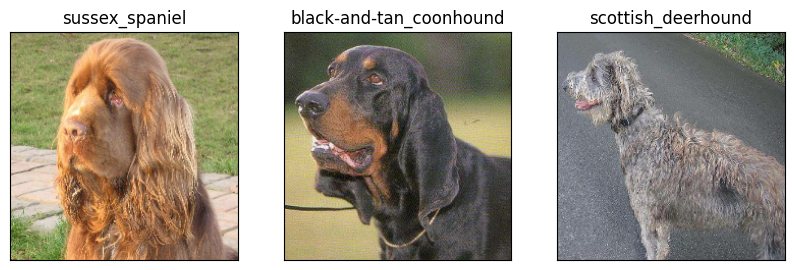

In [110]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)